## 任务一：基于机器学习的文本分类

实现基于logistic/softmax regression的文本分类

1. 参考
   1. [文本分类](文本分类.md)
   2. 《[神经网络与深度学习](https://nndl.github.io/)》 第2/3章
2. 数据集：[Classify the sentiment of sentences from the Rotten Tomatoes dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)
3. 实现要求：NumPy
4. 需要了解的知识点：

   1. 文本特征表示：Bag-of-Word，N-gram
   2. 分类器：logistic/softmax  regression，损失函数、（随机）梯度下降、特征选择
   3. 数据集：训练集/验证集/测试集的划分
5. 实验：
   1. 分析不同的特征、损失函数、学习率对最终分类性能的影响
   2. shuffle 、batch、mini-batch 
6. 时间：两周
- - -

### 包导入
- [jieba](https://www.cnblogs.com/ltb6w/p/10886416.html)：用于分词、统计词频等
- sklearn.feature_extraction.text.CountVectorizer： 文本向量化
- nltk:英文文本处理包

In [1]:
import nltk
import tqdm  # 进度表
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from collections import  Counter

### 导入数据

In [2]:
path = './sentiment-analysis-on-movie-reviews/'

# 创建Setence对象，存放每个句子的特征
class Sentence:
    def __init__(self,sentence,sentiment=None):
        self.sentence = sentence
        self.sentiment = sentiment
        self.wordVector = None
        self.sentiVector = [0,0,0,0,0]

phraseSentimentMap = dict()  # 用于查询每个二元特征（2-gram）对应的情感
sentenceList = []
with open(path+'train.tsv') as f:
    next(f) 
    oldSentenceId = 0
    for content in f:
        content = content.split('\t')
        # 以下四个变量分别为短语和句子id、短语以及短语的情感
        try:
            sentenceId,phrase,sentiment = (int(content[1]),content[2],int(content[3]))
        except:
            print(content[0],content[1],content[2],content[3])
        # 采用二元特征（2-gram），建立短语-情感的映射
        if len(phrase.split())<=2:
            phrase.strip()
            phraseSentimentMap[phrase] =  sentiment
        # 如果是句子，则加入sentenceList
        # 句子一般在同句子序号的第一位
        if sentenceId != oldSentenceId:
            sentenceList.append(Sentence(phrase,sentiment))
            oldSentenceId = sentenceId          

测试

In [3]:
i = 3
print('第{0}句是：\n{1}\n它的情感分类是:{2}'.format(i,sentenceList[i].sentence,sentenceList[i].sentiment))
print('短语库的大小是{0},句子库的大小是{1}'.format(len(phraseSentimentMap),len(sentenceList)))
# print(phraseSentimentMap)

第3句是：
A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .
它的情感分类是:3
短语库的大小是42491,句子库的大小是8529


- [关于迭代变量、迭代器、\_\_iter\_\_()和next()方法的关系](https://blog.csdn.net/Jairoguo/article/details/104483824)
    - 简而言之，list自身不是迭代器，但他可以用iter()方法返回一个list_iterator迭代器
    - 任何迭代器都有__iter__()和__next__()两种方法，分别用于返回自身和进行下一步操作，返回值
    - 迭代器第一次调用__next__()返回的是第一项而不是第二项 

In [4]:
# # 关于next的讨论
# # 说明：__iter__返回一个迭代器（类似指针，指向a的首部），赋给其他变量调用next方法后会指向下一个部分
# # 注意list本身没有next()方法
# a = [1,2,3]
#n = a.__iter__()
# print('a.__iter()__的返回值为 {0}'.format(n))
# print('a.__iter()__的地址为 {0}'.format(id(a.__iter__())))
# print('连续调用n【a返回的迭代器】效果')
# print(next(n))
# print(id(n))
# print(next(n))
# print(id(n))
# print(next(n))
# print(id(n))
# print(next(a.__iter__()))

### 先试着用单词情感作为特征进行预测
考虑到数据库的短语很多，特征不见得很明显；而直接用构成句子的单词具有的情感作为特征，只需要5维，机器学习更快，而且该输入和输出相关性很强，  
所以先试着用每个句子2-gram的5类情感数目作为输入，句子的情感作为输出

#### 1. 确定每个句子的情感矢量

In [5]:
sentimentVectors = []
for s in sentenceList:
    tokens = s.sentence.split()
    tokens2 = list(' '.join(w) for w in nltk.ngrams(tokens, 2))
    vector = np.zeros(5)
    for token in tokens2:
        if token in phraseSentimentMap:
            vector[phraseSentimentMap[token]] += 1
    sentimentVectors.append(vector)
sentimentVectors = np.array(sentimentVectors)

In [6]:
print(sentimentVectors[0:5])

[[ 0.  0. 10.  1.  0.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  1.  6.  0.  0.]
 [ 0.  1.  6.  1.  0.]
 [ 0.  2.  0.  0.  0.]]


#### 2.确定输出

In [7]:
Labels = np.array([s.sentiment for s in sentenceList])

#### 3. 现在我们有了输入和输出，可以开始进行训练了

划分训练集和测试集（kaggle提供的测试集没有标签，所以想知道模型性能得自己划分）

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sentimentVectors, Labels)
print(X_train.shape,X_test.shape)
print(Counter(y_train))
print(Counter(y_test))

(6396, 5) (2133, 5)
Counter({3: 1742, 1: 1667, 2: 1226, 4: 954, 0: 807})
Counter({3: 579, 1: 533, 2: 429, 4: 327, 0: 265})


数据预处理：[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)  
说明：
1. 可能会改变不同标签的大小相对关系（比如变换前[5,1],变换后[0.5,0.4],但空间上看不影响分类，因为是线性变换）
2. 归一化绝对有必要，一来可以加快训练速度【参考吴恩达dl课程】；二来可以防止尺度不一致造成的影响，如本题特征2数最大，相较而言其他数比较小

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # 构造尺度转化对象scaler
X_train = scaler.fit_transform(X_train)  # fit是找出数据的某些特征，transform是基于数据的特征进行转化，注意只有训练集用fit_transform方法
X_test = scaler.transform(X_test)

采用softmax训练

In [10]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression( C= 1.0,class_weight = None)
model.fit(X_train,y_train)

LogisticRegression()

#### 3. 预测并评估结果

Counter({3: 978, 1: 925, 4: 148, 0: 82})


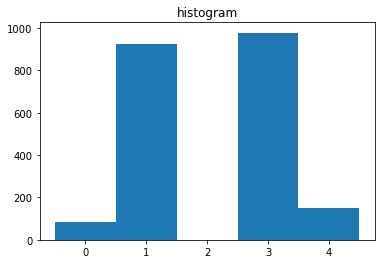

In [11]:
predict = model.predict(X_test)
print(Counter(predict))
plt.hist(predict,bins =  [-0.5,0.5,1.5,2.5,3.5,4.5]) 
plt.title("histogram") 
plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.55      0.17      0.26       265
           1       0.35      0.61      0.44       533
           2       0.00      0.00      0.00       429
           3       0.34      0.58      0.43       579
           4       0.51      0.23      0.32       327

    accuracy                           0.37      2133
   macro avg       0.35      0.32      0.29      2133
weighted avg       0.33      0.37      0.31      2133



F:\anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 4.用回归方式做一次

预处理

In [13]:
X_train, X_test, y_train, y_test = train_test_split(sentimentVectors, Labels)
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler() # 构造尺度转化对象scaler
X_train = scaler.fit_transform(X_train)  # fit是找出数据的某些特征，transform是基于数据的特征进行转化，注意只有训练集用fit_transform方法
X_test = scaler.transform(X_test)

svm回归

In [14]:
from sklearn.svm import SVR
# 学习
model_2 = SVR()
model_2.fit(X_train,y_train)
# 预测
predict_reg = model_2.predict(X_test)
predict = np.array(predict_reg)
hist,bins = np.histogram(predict,bins =  [-0.5,0.5,1.5,2.5,3.5,4.5]) 

# edict = np.rint(predict)
# predict = predict.astype(np.int_)
# print(Counter(predict))
# 评价
#print(classification_report(y_test, predict))

In [15]:
print(hist,bins)

[ 32 460 877 676  88] [-0.5  0.5  1.5  2.5  3.5  4.5]


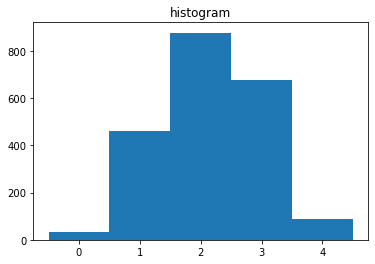

In [16]:
plt.hist(predict,bins =  [-0.5,0.5,1.5,2.5,3.5,4.5]) 
plt.title("histogram") 
plt.show()

In [17]:
# 评价
predict = np.rint(predict)
predict = predict.astype(np.int_)
print(Counter(predict))
print(classification_report(y_test, predict))

Counter({2: 877, 3: 676, 1: 460, 4: 88, 0: 32})
              precision    recall  f1-score   support

           0       0.66      0.09      0.15       244
           1       0.43      0.34      0.38       581
           2       0.26      0.54      0.35       415
           3       0.40      0.47      0.43       571
           4       0.55      0.15      0.23       322

    accuracy                           0.36      2133
   macro avg       0.46      0.32      0.31      2133
weighted avg       0.43      0.36      0.34      2133



贝叶斯岭回归

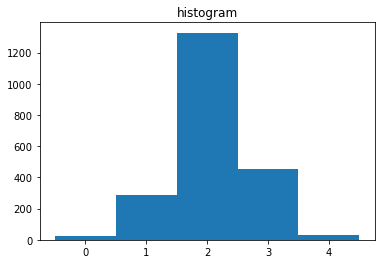

Counter({2: 1327, 3: 451, 1: 286, 4: 38, 0: 31})
              precision    recall  f1-score   support

           0       0.68      0.07      0.13       292
           1       0.37      0.20      0.26       539
           2       0.22      0.75      0.34       392
           3       0.43      0.33      0.37       596
           4       0.63      0.08      0.14       314

    accuracy                           0.30      2133
   macro avg       0.47      0.28      0.25      2133
weighted avg       0.44      0.30      0.27      2133



In [18]:
# 预处理
X_train, X_test, y_train, y_test = train_test_split(sentimentVectors, Labels)
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler() # 构造尺度转化对象scaler
X_train = scaler.fit_transform(X_train)  # fit是找出数据的某些特征，transform是基于数据的特征进行转化，注意只有训练集用fit_transform方法
X_test = scaler.transform(X_test)

# 学习
####3.10ARD贝叶斯ARD回归
from sklearn.linear_model import ARDRegression
ARDRegression = ARDRegression()
ARDRegression.fit(X_train,y_train)
# 预测
predict_reg = ARDRegression.predict(X_test)
predict = np.array(predict_reg)
hist,bins = np.histogram(predict,bins =  [-0.5,0.5,1.5,2.5,3.5,4.5]) 
plt.hist(predict,bins =  [-0.5,0.5,1.5,2.5,3.5,4.5]) 
plt.title("histogram") 
plt.show()
# 评价
predict = np.rint(predict)
predict = predict.astype(np.int_)
predict[predict<0]=0
predict[predict>4]=4
print(Counter(predict))
print(classification_report(y_test, predict))

### 结论
    可以看出，回归取得的效果要比softmax多分类的效果要更好，通过回归的方式几乎都能达到50%的准确性,而softmax显而易见的不善于对中间情况进行分类。